Good instruction of a2c
https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752

### Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for atari [KungFuMaster](https://gym.openai.com/envs/KungFuMaster-v0/) and train it with advantage actor-critic.

![http://www.retroland.com/wp-content/uploads/2011/07/King-Fu-Master.jpg](https://camo.githubusercontent.com/57544b6f5589792d2056107297b1a4bce09ff391/687474703a2f2f7777772e726574726f6c616e642e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031312f30372f4b696e672d46752d4d61737465722e6a7067)

In [1]:
import requests
import sys

In [2]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

For starters, let's take a look at the game itself:
* Image resized to 42x42 and grayscale to run faster
* Rewards divided by 100 'cuz they are all divisible by 100
* Agent sees last 4 frames of game to account for object velocity

In [3]:
import gym
from atari_util import PreprocessAtari

def crop_(img):
    return img[60:-30, 5:]

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop = crop_,
                          dim_order = 'pytorch',
                          color=False, n_frames=4,
                          reward_scale = 0.01)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation shape: (4, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


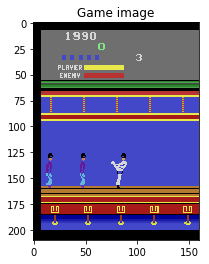

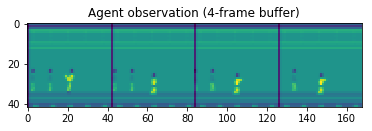

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([1,0,2]).reshape([42,-1]))
plt.show()

### Build an agent

We now have to build an agent for actor-critic training - a convolutional neural network that converts states into action probabilities $\pi$ and state values $V$.

Your assignment here is to build and apply a neural network - with any framework you want. 

For starters, we want you to implement this architecture:
![img](https://github.com/BoYanSTKO/Practical_RL-coursera/blob/master/week5_policy_based/img/nnet_arch.png?raw=true)

After your agent gets mean reward above 50, we encourage you to experiment with model architecture to score even better.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.transforms as T
from torchsummary import summary
import torch.autograd.variable as Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

outputSize(9, 3, 2, 0)

4

In [7]:
class Agent(nn.Module):
    def __init__(self, name, state_shape, n_actions, reuse=False):
        super(Agent, self).__init__()
        """A simple actor-critic agent"""
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.dence1 = nn.Linear(4*4*32, 128)
        self.to_logits = nn.Linear(128, n_actions)
        self.to_value = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = x.view(x.size()[0], -1)
        x = F.elu(self.dence1(x))
        logits = self.to_logits(x)
        state_value = self.to_value(x)
        return logits, state_value
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        # print('logits')
        # print(logits)
        # print('softmax')
        # print(F.softmax(logits, dim=-1))
        dist = Categorical(F.softmax(logits, dim=-1))
        return dist.sample()

In [8]:
agent = Agent("agent", obs_shape, n_actions)

In [9]:
state = torch.as_tensor(env.reset()).unsqueeze(0)
logits, value = agent(state)
print("action logits:\n", logits)
print("state values:\n", value)

print(state.shape)
print(n_actions)

agent.sample_actions((logits, value))[0]

action logits:
 tensor([[ 0.0787, -0.0364,  0.0292,  0.0370,  0.0708,  0.1005, -0.0701,  0.0083,
         -0.0757,  0.0702, -0.0017,  0.0674,  0.0781, -0.0609]],
       grad_fn=<ThAddmmBackward>)
state values:
 tensor([[0.0143]], grad_fn=<ThAddmmBackward>)
torch.Size([1, 4, 42, 42])
14


tensor(8)

### Let's play!
Let's build a function that measures agent's average reward.

In [10]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            state = torch.as_tensor(state).unsqueeze(0)
            action = agent.sample_actions(agent(state))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


### Training on parallel games
![img](https://camo.githubusercontent.com/f894eba2ee745652f1fc95484cfa45bf26decb8e/68747470733a2f2f6769746875622e636f6d2f79616e646578646174617363686f6f6c2f50726163746963616c5f524c2f7261772f6d61737465722f7965745f616e6f746865725f7765656b2f5f7265736f757263652f2f656e765f706f6f6c2e706e67)

To make actor-critic training more stable, we shall play several games in parallel. This means ya'll have to initialize several parallel gym envs, send agent's actions there and .reset() each env if it becomes terminated. To minimize learner brain damage, we've taken care of them for ya - just make sure you read it before you use it.


In [11]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def render(self):
        for i, env in enumerate(self.envs):
            plt.subplot(5, 5, i+1)
            plt.imshow(env.render('rgb_array'))
        plt.show()
        
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        done = done.astype(np.float32())
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

__Let's try it out:__

In [12]:
%%time
env_batch = EnvBatch(10)

batch_states = torch.as_tensor(env_batch.reset()).float()

batch_actions = agent.sample_actions(agent(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shap

# Actor-critic

Here we define a loss functions and learning algorithms as usual.

In [13]:
def gen_actor_critic_loss(agent, states, next_states, rewards, dones, actions, gamma=0.99):
    """
    states, next_states: bx4x42x42 list
    rewards: b list
    dones: b list
    actions: b list
    """
    states = torch.as_tensor(states)
    next_states = torch.as_tensor(next_states)
    rewards = torch.as_tensor(rewards).float().unsqueeze(1)
    dones = torch.as_tensor(dones).float().unsqueeze(1)
    actions = torch.as_tensor(actions).unsqueeze(1)
    
    logits, state_values = agent(states)
    next_logits, next_state_values = agent(next_states)
    next_state_values = next_state_values * (1 - dones)
    
    probs = F.softmax(logits, dim=-1)
    logprobs = F.log_softmax(logits, dim=-1)
    
    probs_actions = probs.gather(1, actions)
    logp_actions = logprobs.gather(1, actions)
    
    advantage = rewards + gamma * next_state_values - state_values
    # from IPython.core.debugger import Pdb; Pdb().set_trace()
    entropy = - torch.sum(probs* logprobs, dim=1)
    actor_loss = - (advantage.detach() * logp_actions).mean() - 0.001 * entropy.mean()
    target_state_values = rewards + gamma * next_state_values
    critic_loss = ((state_values - target_state_values.detach())**2).mean()
    return actor_loss, critic_loss, advantage, entropy

In [14]:
agent = Agent("agent", obs_shape, n_actions)
optimizer = optim.Adam(agent.parameters(), 
                   lr=0.0001)

In [15]:
# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
l_act, l_crit, adv, ent = gen_actor_critic_loss(agent, batch_states, 
                                               batch_next_states, batch_rewards,
                                               batch_done, batch_actions)

#print(l_act)
#print(l_crit)
#print(adv)
#print(ent)
assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2: print("Entropy is too low for untrained agent")
print("You just might be fine!")

You just might be fine!


# Train 

Just the usual - play a bit, compute loss, follow the graidents, repeat a few million times.
![img](http://images6.fanpop.com/image/photos/38900000/Daniel-san-training-the-karate-kid-38947361-499-288.gif)

In [16]:
import pickle

def save_data(folder_path, agent, rewards_history, entropy_history):
    torch.save(agent.state_dict(), folder_path + 'atari_a2c_state_dict.pt')
    with open(folder_path + 'rewards_history.l', 'wb') as f:
        pickle.dump(rewards_history, f)
    with open(folder_path + 'entropy_history.l', 'wb') as f:
        pickle.dump(entropy_history, f)
        

def load_data(folder_path):
    state_dict = None
    rewards_history = []
    entropy_history = []
    
    state_dict = torch.load(folder_path + 'atari_a2c_state_dict.pt')
    with open(folder_path + 'rewards_history.l', 'rb') as f:
        rewards_history = pickle.load(f)
    with open(folder_path + 'entropy_history.l', 'rb') as f:
        entropy_history = pickle.load(f)
        
    return state_dict, rewards_history, entropy_history


rl_path = "./kungfu_data/"

In [17]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
ewma = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [18]:
agent = Agent("agent", obs_shape, n_actions)
optimizer = optim.Adam(agent.parameters(), 
                   lr=0.0001)

In [19]:
# Load the data
state_dict, rewards_history, entropy_history = load_data(rl_path)
agent.load_state_dict(state_dict)

In [19]:
# send notification to line
url = "https://notify-api.line.me/api/notify"
line_token = "uWuRHE8rbKHZ4vp8wk4Ohfgq7bVlvQkzX6YUz8SAsdO"
headers = {"Authorization" : "Bearer "+ line_token}

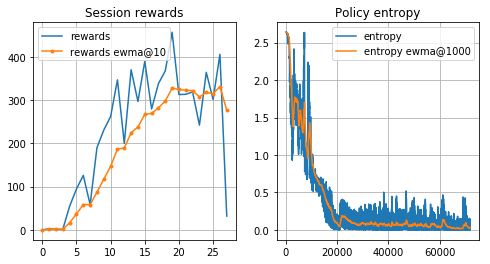

 72%|███████▎  | 72500/100000 [2:16:40<32:38, 14.04it/s]  

In [ ]:
%%time
for i in trange(100000): 
    batch_states = torch.as_tensor(batch_states)
    batch_actions = agent.sample_actions(agent(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    l_act, l_crit, adv, ent_t = gen_actor_critic_loss(agent, batch_states, 
                                               batch_next_states, batch_rewards,
                                               batch_done, batch_actions)
    # print('l_act')
    # print(l_act)
    # print('l_crit')
    # print(l_crit)
    optimizer.zero_grad()
    loss = l_act + l_crit
    loss.backward()
    optimizer.step()
    
    entropy_history.append(ent_t.mean())

    batch_states = batch_next_states
    
    # if i % 100 == 0:
    #     print(batch_actions)
    #     env_batch.render()
        
    if i % 500 == 0: 
        if i != 0 and i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            save_data(rl_path, agent, rewards_history, entropy_history)
            message = 'passed episode number: ' + str(i)
            payload = {"message" :  message}
            files = {"imageFile": open(rl_path+'image.jpg', "rb")}
            requests.post(url ,headers = headers ,params=payload, files=files)
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")

        clear_output(True)
        
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history),span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(ewma(np.array(entropy_history),span=1000), label='entropy ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.savefig(rl_path+'image.jpg')
        plt.show()

# shutdown
import subprocess
subprocess.run(('/sbin/shutdown', '-h', 'now'))

In [ ]:
import torch.multiprocessing as mp
import parallel
mp.set_start_method('spawn', force=True)

In [ ]:
parent, child = mp.Pipe()
proc = mp.Process(target=parallel.evaluateMP, args=(child, agent, env))
proc.start()
reward = parent.recv()
proc.join()

Relax and grab some refreshments while your agent is locked in an infinite loop of violence and death.

__How to interpret plots:__

The session reward is the easy thing: it should in general go up over time, but it's okay if it fluctuates ~~like crazy~~. It's also OK if it reward doesn't increase substantially before some 10k initial steps. However, if reward reaches zero and doesn't seem to get up over 2-3 evaluations, there's something wrong happening.


Since we use a policy-based method, we also keep track of __policy entropy__ - the same one you used as a regularizer. The only important thing about it is that your entropy shouldn't drop too low (`< 0.1`) before your agent gets the yellow belt. Or at least it can drop there, but _it shouldn't stay there for long_.

If it does, the culprit is likely:
* Some bug in entropy computation. Remember that it is $ - \sum p(a_i) \cdot log p(a_i) $
* Your agent architecture converges too fast. Increase entropy coefficient in actor loss. 
* Gradient explosion - just [clip gradients](https://stackoverflow.com/a/43486487) and maybe use a smaller network
* Us. Or TF developers. Or aliens. Or lizardfolk. Contact us on forums before it's too late!

If you're debugging, just run `logits, values = agent.step(batch_states)` and manually look into logits and values. This will reveal the problem 9 times out of 10: you'll likely see some NaNs or insanely large numbers or zeros. Try to catch the moment when this happens for the first time and investigate from there.

### "Final" evaluation

In [20]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

Final mean reward: 336.6


In [23]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) 

In [22]:
#show video#show v 
from IPython.display import HTML
import os

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-2])) #try other indices 

In [11]:
# if you don't see videos, just navigate to ./kungfu_videos and download .mp4 files from there.

In [12]:
from submit import submit_kungfu
env = make_env()
submit_kungfu(agent, env, evaluate, "syuntoku14@gmail.com", "SmDDRq4iWxIZ2lQ7")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Submitted to Coursera platform. See results on assignment page!


### Now what?
Well, 5k reward is [just the beginning](https://www.buzzfeed.com/mattjayyoung/what-the-color-of-your-karate-belt-actually-means-lg3g). Can you get past 200? With recurrent neural network memory, chances are you can even beat 400!

* Try n-step advantage and "lambda"-advantage (aka GAE) - see [this article](https://arxiv.org/abs/1506.02438)
 * This change should improve early convergence a lot
* Try recurrent neural network 
 * RNN memory will slow things down initially, but in will reach better final reward at this game
* Implement asynchronuous version
 * Remember [A3C](https://arxiv.org/abs/1602.01783)? The first "A" stands for asynchronuous. It means there are several parallel actor-learners out there.
 * You can write custom code for synchronization, but we recommend using [redis](https://redis.io/)
   * You can store full parameter set in redis, along with any other metadate
   * Here's a _quick_ way to (de)serialize parameters for redis
   ```
   import joblib
   from six import BytesIO
```
```
   def dumps(data):
        "converts whatever to string"
        s = BytesIO()
        joblib.dump(data,s)
        return s.getvalue()
``` 
```
    def loads(string):
        "converts string to whatever was dumps'ed in it"
        return joblib.load(BytesIO(string))
```